# T81-558: Applications of Deep Neural Networks
**Class 9: Regularization: L1, L2 and Dropout**
* Instructor: [Jeff Heaton](https://sites.wustl.edu/jeffheaton/), School of Engineering and Applied Science, [Washington University in St. Louis](https://engineering.wustl.edu/Programs/Pages/default.aspx)
* For more information visit the [class website](https://sites.wustl.edu/jeffheaton/t81-558/).

# Regularization

Regularization is a technique that reduces overfitting, which occurs when neural networks attempt to memorize training data, rather than learn from it.  Humans are capable of overfitting as well.  Before we examine the ways that a machine accidentally overfits, we will first explore how humans can suffer from it.

Human programmers often take certification exams to show their competence in a given programming language.  To help prepare for these exams, the test makers often make practice exams available.  Consider a programmer who enters a loop of taking the practice exam, studying more, and then taking the practice exam again.  At some point, the programmer has memorized much of the practice exam, rather than learning the techniques necessary to figure out the individual questions.  The programmer has now overfit to the practice exam.  When this programmer takes the real exam, his actual score will likely be lower than what he earned on the practice exam.
 
 A computer can overfit as well.  Although a neural network received a high score on its training data, this result does not mean that the same neural network will score high on data that was not inside the training set.  Regularization is one of the techniques that can prevent overfitting. A number of different regularization techniques exist.  Most work by analyzing and potentially modifying the weights of a neural network as it trains.  


# Helpful Functions

We've used these functions before, they are just to help process the data.

In [1]:
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df,name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name,x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)

# Encode text values to a single dummy variable.  The new columns (which do not replace the old) will have a 1
# at every location where the origional column (name) matches each of the target_values.  One column is added for
# each target value.
def encode_text_single_dummy(df,name,target_values):
    for tv in target_values:
        l = list(df[name].astype(str))
        l = [1 if str(x)==str(tv) else 0 for x in l]
        name2 = "{}-{}".format(name,tv)
        df[name2] = l
    
# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df,name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_

# Encode a numeric column as zscores
def encode_numeric_zscore(df,name,mean=None,sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name]-mean)/sd

# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)

# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)

# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df,target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)

    # find out the type of the target column.  Is it really this hard? :(
    target_type = df[target].dtypes
    target_type = target_type[0] if hasattr(target_type, '__iter__') else target_type
    
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.int32)
    else:
        # Regression
        return df.as_matrix(result).astype(np.float32),df.as_matrix([target]).astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)

# Regression chart, we will see more of this chart in the next class.
def chart_regression(pred,y):
    t = pd.DataFrame({'pred' : pred, 'y' : y_test.flatten()})
    t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()
    
# Get a new directory to hold checkpoints from a neural network.  This allows the neural network to be
# loaded later.  If the erase param is set to true, the contents of the directory will be cleared.
def get_model_dir(name,erase):
    base_path = os.path.join(".","dnn")
    model_dir = os.path.join(base_path,name)
    os.makedirs(model_dir,exist_ok=True)
    if erase and len(model_dir)>4 and os.path.isdir(model_dir):
        shutil.rmtree(model_dir,ignore_errors=True) # be careful, this deletes everything below the specified path
    return model_dir

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name]-df[name].mean())>=(sd*df[name].std()))]
    df.drop(drop_rows,axis=0,inplace=True)
    
# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low =-1, normalized_high =1, 
                         data_low=None, data_high=None):
    
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])
    
    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
                * (normalized_high - normalized_low) + normalized_low

In [2]:
# Simple function to evaluate the coefficients of a regression
%matplotlib inline    
from IPython.display import display, HTML    

def report_coef(names,coef,intercept):
    r = pd.DataFrame( { 'coef': coef, 'positive': coef>=0  }, index = names )
    r = r.sort_values(by=['coef'])
    display(r)
    print("Intercept: {}".format(intercept))
    r['coef'].plot(kind='barh', color=r['positive'].map({True: 'b', False: 'r'}))


# Setup Data

We are going to look at linear regression to see how L1 and L2 regularization work.  The following code sets up the auto-mpg data for this purpose.

In [3]:
from sklearn.linear_model import LassoCV
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore
from sklearn.model_selection import train_test_split 

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
# Do not need zscore standardization for linear regression
#encode_numeric_zscore(df, 'horsepower')
#encode_numeric_zscore(df, 'weight')
#encode_numeric_zscore(df, 'cylinders')
#encode_numeric_zscore(df, 'displacement')
#encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
        

# Linear Regression

To understand L1/L2 regularization, it is good to start with linear regression.  L1/L2 were first introduced for linear regression.  They can also be used for neural networks.  To fully understand L1/L2 we will begin with how they are used with linear regression.

The following code uses linear regression to fit the auto-mpg data set.  The RMSE reported will not be as good as a neural network.

Final score (RMSE): 2.9371568088532114


,coef,positive
origin-1,-1.448373,False
cylinders,-0.416543,False
horsepower,-0.007785,False
weight,-0.007473,False
displacement,0.024456,True
acceleration,0.138122,True
origin-3,0.629808,True
year,0.801274,True
origin-2,0.818565,True


Intercept: [-18.25751796]


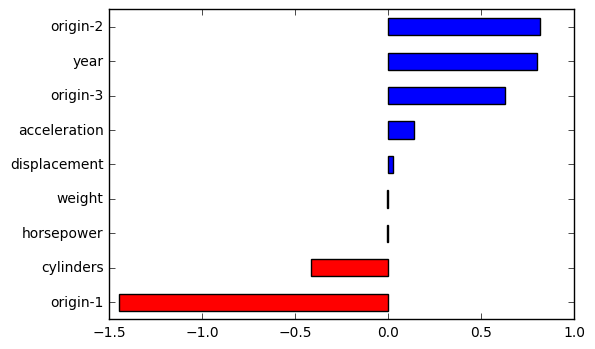

In [4]:
import sklearn

# Create linear regression
regressor = sklearn.linear_model.LinearRegression()

# Fit/train linear regression
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


# L1 (Lasso) Regularization

L1 Regularization, also called LASSO (Least Absolute Shrinkage and Selection Operator) is should be used to create sparsity in the neural network. In other words, the L1 algorithm will push many weight connections to near 0.  When a weight is near 0, the program drops it from the network.  Dropping weighted connections will create a sparse neural network.

Feature selection is a useful byproduct of sparse neural networks. Features are the values that the training set provides to the input neurons.  Once all the weights of an input neuron reach 0, the neural network training determines that the feature is unnecessary.  If your data set has a large number of input features that may not be needed, L1 regularization can help the neural network detect and ignore unnecessary features.

L1 is implemented by adding the following error to the objective to minimize:

$$ E_1 = \alpha \sum_w{ |w| } $$

The following code demonstrates lasso regression.  Notice the effect of the coefficients compared to the previous section that used linear regression.

Final score (RMSE): 3.0409040451049805


,coef,positive
origin-1,-1.264483,False
weight,-0.007458,False
horsepower,-0.002799,False
cylinders,-0.000000,True
origin-2,0.000000,True
origin-3,0.000000,True
displacement,0.013005,True
acceleration,0.113755,True
year,0.787194,True


Intercept: [-17.27110481]


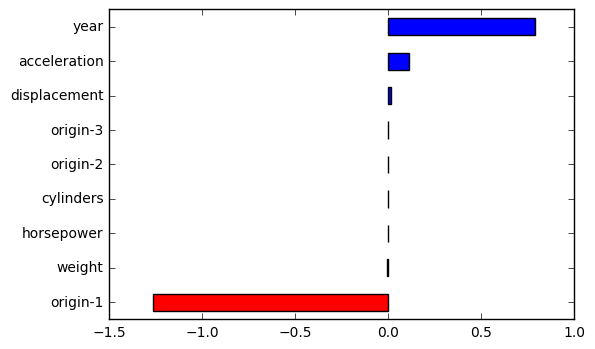

In [5]:
import sklearn
from sklearn.linear_model import Lasso

# Create linear regression
regressor = Lasso(random_state=0,alpha=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)


C:\Users\jeffh\Anaconda3\envs\gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jeffh\Anaconda3\envs\gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jeffh\Anaconda3\envs\gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
C:\Users\jeffh\Anaconda3\envs\gpu\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did no

(1e-08, 100000000.0)

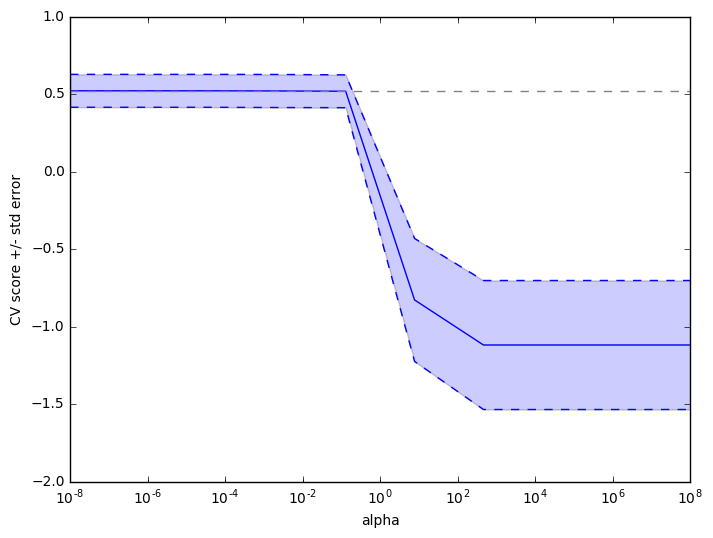

In [12]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

lasso = Lasso(random_state=42)
alphas = np.logspace(-8, 8, 10)

scores = list()
scores_std = list()

n_folds = 3

for alpha in alphas:
    lasso.alpha = alpha
    this_scores = cross_val_score(lasso, x, y, cv=n_folds, n_jobs=1)
    scores.append(np.mean(this_scores))
    scores_std.append(np.std(this_scores))

scores, scores_std = np.array(scores), np.array(scores_std)

plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# L2 (Ridge) Regularization

You should use Tikhonov/Ridge/L2 regularization when you are less concerned about creating a space network and are more concerned about low weight values.  The lower weight values will typically lead to less overfitting. 

$$ E_1 = \alpha \sum_w{ w^2 } $$

Like the L1 algorithm, the $\alpha$ value determines how important the L2 objective is compared to the neural network’s error.  Typical L2 values are below 0.1 (10%).  The main calculation performed by L2 is the summing of the squares of all of the weights.  The bias values are not summed.

The following code uses L2 with linear regression (Ridge regression):

Final score (RMSE): 2.9413154427467068


,coef,positive
origin-1,-1.420925,False
cylinders,-0.409651,False
horsepower,-0.007524,False
weight,-0.007473,False
displacement,0.024128,True
acceleration,0.137985,True
origin-3,0.619104,True
year,0.800769,True
origin-2,0.801821,True


Intercept: [-18.23057194]


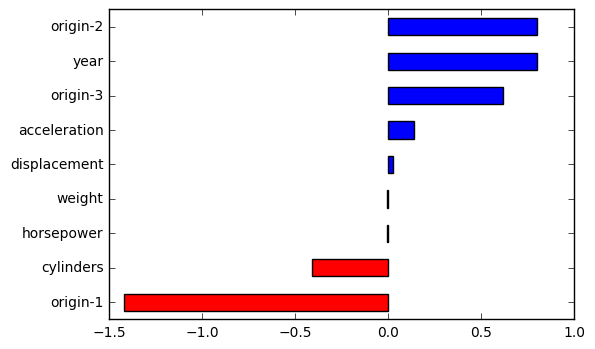

In [7]:
import sklearn
from sklearn.linear_model import Ridge

# Create linear regression
regressor = Ridge(alpha=1)

# Fit/train Ridge
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_[0,:],
  regressor.intercept_)


Final score (RMSE): 3.031985282897949


,coef,positive
origin-1,-0.938925,False
cylinders,-0.257571,False
weight,-0.007462,False
horsepower,-0.002896,False
displacement,0.017533,True
acceleration,0.131321,True
origin-3,0.369088,True
origin-2,0.458725,True
year,0.788913,True


Intercept: [-17.48011208]


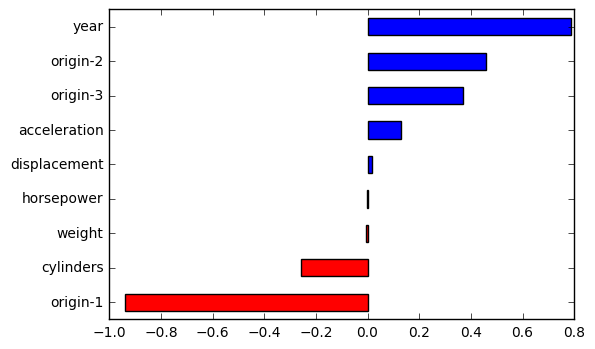

In [8]:
import sklearn
from sklearn.linear_model import ElasticNet

# Create linear regression
regressor = ElasticNet(alpha=0.1, l1_ratio=0.1)

# Fit/train LASSO
regressor.fit(x_train,y_train)
# Predict
pred = regressor.predict(x_test)

# Measure RMSE error.  RMSE is common for regression.
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Final score (RMSE): {}".format(score))

names = list(df.columns.values)
names.remove("mpg")
report_coef(
  names,
  regressor.coef_,
  regressor.intercept_)

# TensorFlow and L1/L2

L1 and L2 regularization are two common regularization techniques that can reduce the effects of overfitting (Ng, 2004).  Both of these algorithms can either work with an objective function or as a part of the backpropagation algorithm.  In both cases the regularization algorithm is attached to the training algorithm by adding an additional objective.  

Both of these algorithms work by adding a weight penalty to the neural network training.  This penalty encourages the neural network to keep the weights to small values.  Both L1 and L2 calculate this penalty differently.  For gradient-descent-based algorithms, such as backpropagation, you can add this penalty calculation to the calculated gradients.  For objective-function-based training, such as simulated annealing, the penalty is negatively combined with the objective score.

Both L1 and L2 work differently in the way that they penalize the size of a weight.  L1 will force the weights into a pattern similar to a Gaussian distribution; the L2 will force the weights into a pattern similar to a Laplace distribution, as demonstrated the following:

![L1 vs L2](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_l1_l2.png "L1 vs L2")

As you can see, L1 algorithm is more tolerant of weights further from 0, whereas the L2 algorithm is less tolerant.  We will highlight other important differences between L1 and L2 in the following sections.  You also need to note that both L1 and L2 count their penalties based only on weights; they do not count penalties on bias values.

Tensor flow allows [l1/l2 to be directly added to your network](http://tensorlayer.readthedocs.io/en/stable/modules/cost.html).

Animation that shows how [dropout works](https://yusugomori.com/projects/deep-learning/dropout-relu)

Score (RMSE): 3.050769567489624


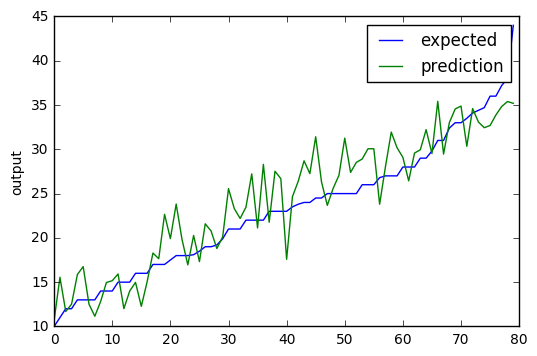

In [9]:
########################################
# TensorFlow with L1/L2 for Regression
########################################
%matplotlib inline
from matplotlib.pyplot import figure, show
import tensorflow.contrib.learn as learn
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
import os
import numpy as np
from sklearn import metrics
from scipy.stats import zscore

path = "./data/"

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.20, random_state=42)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mpg',True)

# Choose an optimizer
opt=tf.train.AdagradDAOptimizer(
    learning_rate=0.01,    
    global_step = 1,
    l1_regularization_strength=0.0,
    l2_regularization_strength=1e-5)
#opt=tf.train.MomentumOptimizer(learning_rate=0.000001,momentum=0.9)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir,
    #optimizer=opt,
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50,25,5])

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=100,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=100)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],batch_size=32,steps=10000)

# Predict and measure RMSE
pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

# Plot the chart
chart_regression(pred,y_test)

# Dropout Regularization

Most neural network frameworks implement dropout as a separate layer.  Dropout layers function as a regular, densely connected neural network layer.  The only difference is that the dropout layers will periodically drop some of their neurons during training.  You can use dropout layers on regular feedforward neural networks. In fact, they can also become layers in convolutional LeNET-5 networks like we studied in class 8.

The usual hyper-parameters for a dropout layer are the following:
* Neuron Count
* Activation Function
* Dropout Probability

The neuron count and activation function hyper-parameters work exactly the same way as their corresponding parameters in the dense layer type mentioned previously. The neuron count simply specifies the number of neurons in the dropout layer.  The dropout probability indicates the likelihood of a neuron dropping out during the training iteration.  Just as it does for a dense layer, the program specifies an activation function for the dropout layer.

![Dropout Regularization](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_9_dropout.png "Dropout Regularization")

A certain percentage neurons we be masked during each training step.  All neurons return after training is complete.  To make use of dropout in TF Learn use the **dropout** parameter of either **DNNClassifier** or **DNNRegressor**.  This is the percent of neurons to be dropped.  Typically this is a low value, such as 0.1.

In [10]:
############################################
# TensorFlow with Dropout for Classification
############################################
import os
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow.contrib.learn as learn
import tensorflow as tf
import numpy as np

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"
    
filename = os.path.join(path,"iris.csv")    
df = pd.read_csv(filename,na_values=['NA','?'])

# Encode feature vector
encode_numeric_zscore(df,'petal_w')
encode_numeric_zscore(df,'petal_l')
encode_numeric_zscore(df,'sepal_w')
encode_numeric_zscore(df,'sepal_l')
species = encode_text_index(df,"species")
num_classes = len(species)

# Create x & y for training

# Create the x-side (feature vectors) of the training
x, y = to_xy(df,'species')
    
# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(    
    x, y, test_size=0.25, random_state=45) 
    # as much as I would like to use 42, it gives a perfect result, and a boring confusion matrix!
    
# Get/clear a directory to store the neural network to
model_dir = get_model_dir('iris',True)

# Create a deep neural network with 3 hidden layers of 10, 20, 5
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
classifier = learn.DNNClassifier(
    model_dir= model_dir, dropout = 0.2,  # the probability we will drop out a given coordinate.
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    hidden_units=[10, 20, 5], n_classes=num_classes, feature_columns=feature_columns)

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    #metrics=validation_metrics,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
classifier.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

# Measure accuracy
pred = list(classifier.predict(x_test, as_iterable=True))
score = metrics.accuracy_score(y_test, pred)
print("Final accuracy: {}".format(score))

Final accuracy: 0.9736842105263158


In [11]:
########################################
# TensorFlow with Dropout for Regression
########################################
import tensorflow.contrib.learn as learn
import pandas as pd
import os
import numpy as np
import tensorflow as tf
from sklearn import metrics
from scipy.stats import zscore

# Set the desired TensorFlow output level for this example
tf.logging.set_verbosity(tf.logging.ERROR)

path = "./data/"

filename_read = os.path.join(path,"auto-mpg.csv")
df = pd.read_csv(filename_read,na_values=['NA','?'])

# create feature vector
missing_median(df, 'horsepower')
df.drop('name',1,inplace=True)
encode_numeric_zscore(df, 'horsepower')
encode_numeric_zscore(df, 'weight')
encode_numeric_zscore(df, 'cylinders')
encode_numeric_zscore(df, 'displacement')
encode_numeric_zscore(df, 'acceleration')
encode_text_dummy(df, 'origin')

# Encode to a 2D matrix for training
x,y = to_xy(df,'mpg')

# Split into train/test
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.25, random_state=42)

# Get/clear a directory to store the neural network to
model_dir = get_model_dir('mpg',True)

# Create a deep neural network with 3 hidden layers of 50, 25, 10
feature_columns = [tf.contrib.layers.real_valued_column("", dimension=x.shape[0])]
regressor = learn.DNNRegressor(
    model_dir= model_dir, dropout = 0.2,  # the probability we will drop out a given coordinate.
    config=tf.contrib.learn.RunConfig(save_checkpoints_secs=1),
    feature_columns=feature_columns,
    hidden_units=[50, 25, 10])

# Might be needed in future versions of "TensorFlow Learn"
#classifier = learn.SKCompat(classifier) # For Sklearn compatibility

# Early stopping
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    x_test,
    y_test,
    every_n_steps=500,
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=50)
    
# Fit/train neural network
regressor.fit(x_train, y_train,monitors=[validation_monitor],steps=10000)

# Predict and measure RMSE
pred = list(regressor.predict(x_test, as_iterable=True))
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Score (RMSE): 6.204305648803711
